# Import

In [1]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [3]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_1_layout import layout
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
data_type = "20News"
vectorize_types = ["doc2vec", "sentenceBERT"]

# Read data

In [6]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [7]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [9]:
vector_dims = {"doc2vec": config["vectorize"]["doc2vec"]["dims"], "sentenceBERT": [384]}
model_nums = config["clustering"]["gmm"]["max_model_num"]
vector_model_num = config["vectorize"]["doc2vec"]["max_model_num"]
normalization = "centralized"
covariance_types = ["spherical", "diag", "full"]

In [10]:
stats_vals = ["mi"]

In [11]:
def get_stats_vals(
    data_type, vectorize_type, covariance_types, normalization, stats_vals
):
    # データ型定義
    stats = {
        stats_val: {
            covariance_type: {
                model_num: pd.DataFrame for model_num in range(model_nums)
            }
            for covariance_type in covariance_types
        }
        for stats_val in stats_vals
    }

    # データ取得
    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            for model_num in range(model_nums):
                stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{normalization}/{covariance_type}/{model_num}.csv"
                df = pd.read_csv(stats_path, index_col=0)
                stats[stats_val][covariance_type][model_num] = df.loc[:, stats_val]
    return stats

In [12]:
stats = {
    vectorize_type: get_stats_vals(
        data_type, vectorize_type, covariance_types, normalization, stats_vals
    )
    for vectorize_type in vectorize_types
}

In [13]:
stats_const = {
    vectorize_type: get_stats_vals(
        data_type, vectorize_type, covariance_types, normalization, stats_vals
    )
    for vectorize_type in vectorize_types
}

In [14]:
lda_mi = pd.read_csv(f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0)

In [15]:
describe_lda_mi, _ = get_describe(lda_mi, axis=0)

# Data shaping

In [16]:
def make_stats_df(stats, covariance_types, stats_vals):
    stats_df = {
        stats_val: {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            # model_numについて取得データstatsを結合
            stats_df[stats_val][covariance_type] = pd.concat(
                stats[stats_val][covariance_type], axis=1
            )
    return stats_df

In [17]:
stats_df = {
    vectorize_type: make_stats_df(stats[vectorize_type], covariance_types, stats_vals)
    for vectorize_type in vectorize_types
}

In [18]:
def make_describe(stats_df, covariance_type, stats_vals):
    describe = {
        stats_val: {covariance_type: dict() for covariance_type in covariance_types}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            describe[stats_val][covariance_type], describe_keys = get_describe(
                stats_df[stats_val][covariance_type], axis=1
            )
    return describe, describe_keys

In [19]:
describe = {vectorize_type: {} for vectorize_type in vectorize_types}
for vectorize_type in vectorize_types:
    _describe, describe_keys = make_describe(stats_df[vectorize_type], covariance_types, stats_vals)
    describe[vectorize_type] = _describe

In [20]:
def make_data(describe, covariance_types, stats_vals, describe_keys):
    data = {
        stats_val: {describe_key: pd.DataFrame() for describe_key in describe_keys}
        for stats_val in stats_vals
    }
    for stats_val in stats_vals:
        for describe_key in describe_keys:
            # covariance_typeについてデータを結合
            _data = {
                covariance_type: describe[stats_val][covariance_type][describe_key]
                for covariance_type in covariance_types
            }
            data[stats_val][describe_key] = pd.concat(_data, axis=1)
    return data

In [21]:
data = {
    vectorize_type: make_data(
        describe[vectorize_type], covariance_types, stats_vals, describe_keys
    )
    for vectorize_type in vectorize_types
}

In [22]:
for covariance_type in covariance_types:
    data["sentenceBERT"]["mi"]["mean"].loc[384, covariance_type]

In [23]:
error_low = {
    vectorize_type: data[vectorize_type]["mi"]["std"]
    for vectorize_type in vectorize_types
}
error_upper = {
    vectorize_type: data[vectorize_type]["mi"]["std"]
    for vectorize_type in vectorize_types
}
title = f"{data_type}    ({vectorize_type})"
xlabel = "埋め込み次元"
ylabel = "mi"
yticks = np.arange(0, 0.7, 0.1)
# path = fig_path

In [24]:
cycler = {
    "color":
    [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ],
}

In [25]:
vectorize_labels = {
    "doc2vec": "doc2vec",
    "sentenceBERT": "SBERT"
}

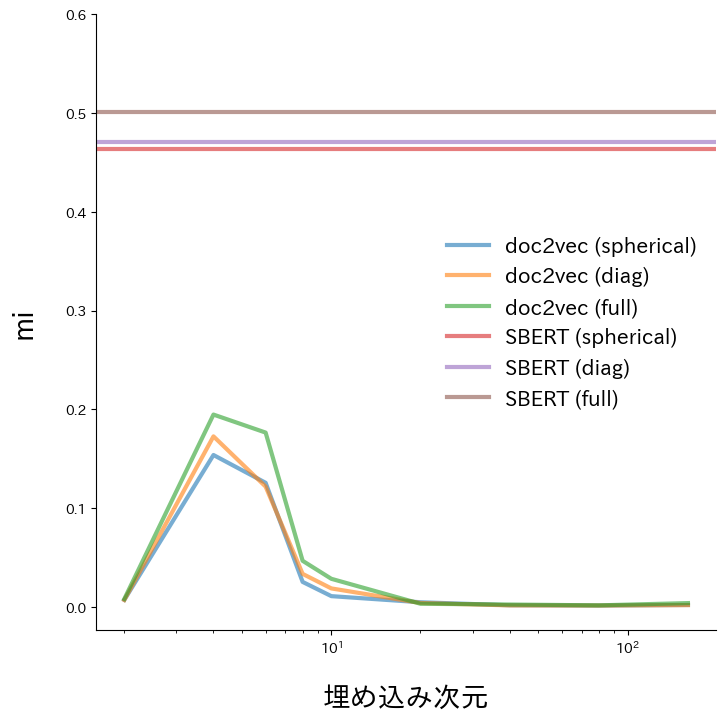

In [26]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/StatsCovariance{data_type}.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for column in data["doc2vec"]["mi"]["mean"].columns:
    ax.plot(
        data["doc2vec"]["mi"]["mean"].index.to_numpy(),
        data["doc2vec"]["mi"]["mean"].loc[:, column].to_numpy(),
        label=f"doc2vec ({column})",
        **layout["plot"],
    )

for i, covariance_type in enumerate(covariance_types):
    ax.axhline(
        y=data["sentenceBERT"]["mi"]["mean"].loc[384, covariance_type],
        label=f"SBERT ({covariance_type})",
        color=cycler["color"][i + 3],
        **layout["plot"]
    )

# ax.set_title(title, **layout["title"])

ax.set_xlabel(xlabel, **layout["label"])
ax.set_ylabel(ylabel, **layout["label"])
ax.set_yticks(ticks=yticks, **layout["ticks"])
ax.legend(**layout["legend"])

fig.savefig(make_filepath(fig_path))